<a href="https://colab.research.google.com/github/alejandro-cermeno/2021_Market_Timing-Cermeno/blob/main/arima_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### El modelo ARIMA de Box and Jenkins (1970)

Alejandro Cermeño 

06/2021

## Procedimientos preliminares



1.   Se importan las librerías necesarias
2.   Se importan las series de precios $\left(y_{t}\right)$
3.   Se calcula el logaritmo de los retornos  $y_{t}=100\times\left[\log\left(p_{t}\right)-\log\left(p_{t-1}\right)\right]$
4.   Estadísticos descriptivos
5.   Se configura el output en ${\LaTeX}$

In [ ]:
%%capture
!pip install pmdarima
!pip install arch

In [ ]:
# Configuración premiliminar

    # Librerias necesarias
import os
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import pyplot
import math
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import train_test_split
import pmdarima # Taylor (2017)
import arch     # Sheppard (2021)
from google.colab import drive
    # Directorio 
#drive.mount('/content/drive')
#os.chdir('/content/drive/MyDrive/TESIS/2021_Market_Timing-Cermeño/Code')



# Obtencion de datos
ruta_git = 'https://git.io/Jnovh'
series = pd.read_excel(ruta_git, sheet_name = 'source', index_col = 0)



# Transformacion a retornos logarítmicos
logret_series = (100 * (np.log(series) - np.log(series.shift(1))))



# Tabla de estadisticos descriptivos
descriptivos = pd.concat([logret_series.describe()\
                          .loc[['count','std', 'min', 'max']].T, 
                          series.skew().rename('skew'),series.kurt().\
                          rename('kurt')], axis=1).round(2)
    # Se agregan las fechas de inicio
fecha_inicio = logret_series.apply(lambda logret_series: logret_series.first_valid_index())
fecha_inicio = pd.DataFrame(fecha_inicio, columns=['Fecha Inicio'])
    # Se agregan las fechas de fin
fecha_fin = logret_series.apply(lambda logret_series: logret_series.last_valid_index())
fecha_fin = pd.DataFrame(fecha_fin, columns=['Fecha Fin'])

descriptivos = pd.concat([fecha_inicio, fecha_fin, descriptivos], axis = 1)

    # Configuración del output
print('Precio de cierre de los indices LATAM')
display(series.head())
print('')
print('')
print('Retornos de los indices LATAM')
display(logret_series.head())
print('')
print('')
print('Estadísticos descriptivos de los retornos')
display(descriptivos)
print('')
print('')
print('LaTeX - Estadísticos descriptivos de los retornos')
print(descriptivos.to_latex()) # Se configura el output a LaTeX

Precio de cierre de los indices LATAM


,ipsa,mexbol,spblpgpt
Dates,,,
1990-08-08,92.18,NaN,NaN
1990-08-09,92.10,NaN,NaN
1990-08-10,93.28,NaN,NaN
1990-08-13,93.51,NaN,NaN
1990-08-14,93.64,NaN,NaN




Retornos de los indices LATAM


,ipsa,mexbol,spblpgpt
Dates,,,
1990-08-08,NaN,NaN,NaN
1990-08-09,-0.086824,NaN,NaN
1990-08-10,1.273078,NaN,NaN
1990-08-13,0.246266,NaN,NaN
1990-08-14,0.138926,NaN,NaN




Estadísticos descriptivos de los retornos


,Fecha Inicio,Fecha Fin,count,std,min,max,skew,kurt
ipsa,1990-08-09,2021-05-31,8038.0,1.14,-15.22,11.80,0.28,-1.41
mexbol,1994-03-31,2021-05-31,7088.0,1.40,-14.31,12.15,0.04,-1.65
spblpgpt,2002-02-07,2021-05-31,5038.0,1.34,-13.29,12.82,-0.58,-0.96




LaTeX - Estadísticos descriptivos de los retornos
\begin{tabular}{lllrrrrrr}
\toprule
{} & Fecha Inicio &  Fecha Fin &   count &   std &    min &    max &  skew &  kurt \\
\midrule
ipsa     &   1990-08-09 & 2021-05-31 &  8038.0 &  1.14 & -15.22 &  11.80 &  0.28 & -1.41 \\
mexbol   &   1994-03-31 & 2021-05-31 &  7088.0 &  1.40 & -14.31 &  12.15 &  0.04 & -1.65 \\
spblpgpt &   2002-02-07 & 2021-05-31 &  5038.0 &  1.34 & -13.29 &  12.82 & -0.58 & -0.96 \\
\bottomrule
\end{tabular}



# **Gráficos**


In [ ]:
def graficos(df, titulos):

  from math import ceil         # Aproxima los decimales al inmediato superior

  # Numero de filas y columnas
  nrows = ceil(df.shape[1] / 2) # Las filas serán la cantidad de series entre 2
  ncols = 2                     # El gráfico solo tendrá dos columnas

  fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  for col, ax in zip(df.columns, axes.flatten()):
    ax.plot(df.index, df[col])
    ax.set_xlabel(titulos[df.columns.get_loc(col)], fontsize=15)
    ax.grid()

  axes[1,nrows-1].set_axis_off() # Según sea el caso, elimina la subfigura extra

**Gráfico del precio de los indices bursátiles LATAM**

<div style="text-align: right">Se toma el precio de cierre en frecuencia diaria para los índices bursátiles de los mercados latinoamericanos de Bloomberg Financial Data. Todas las series terminan el 31 junio de 2021 e inician en diferentes fechas segun según disponibilidad: 9 de agosto de 1990 (Chile), 31 de marzo de 1994 (México) y 7 de febrero de 2002 (Perú). </div>

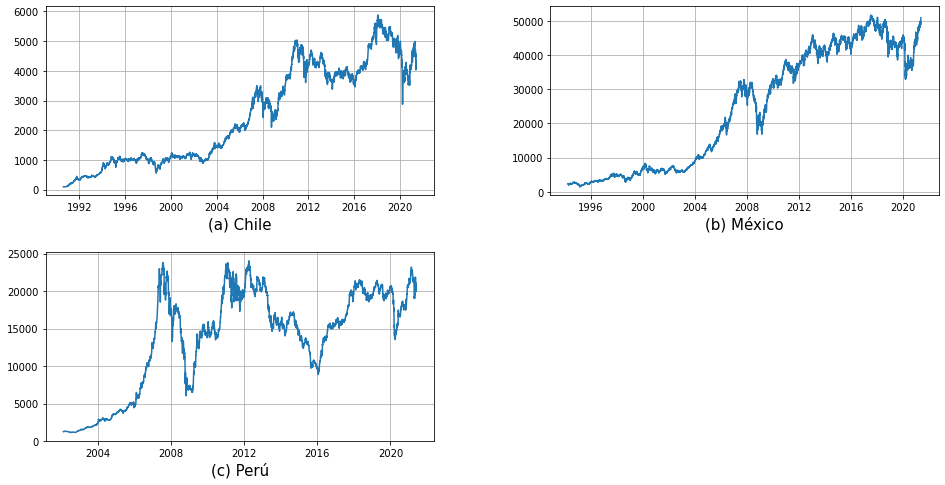

In [ ]:
paises = ['(a) Chile', '(b) México', '(c) Perú']
graficos(series, paises)

plt.savefig('grafico_1_precios')

**Gráfico de los retornos de los índices bursátiles LATAM**

<div style="text-align: right"> Sea $p_{t}$ el precio en el periodo t, el retorno se define como la variación porcentual en logaritmos del precio según $y_{t}=100\times\left[\log\left(p_{t}\right)-\log\left(p_{t-1}\right)\right]$. </div>


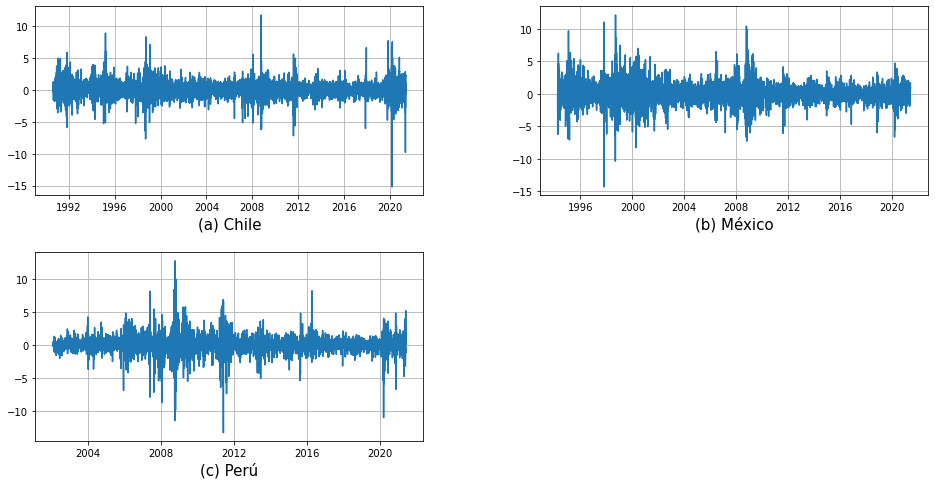

In [ ]:
paises = ['(a) Chile', '(b) México', '(c) Perú']
graficos(logret_series, paises)

plt.savefig('grafico_2_retornos')

# **Estacionariedad de las series**

**Prueba de Dickey-Fuller Aumentada (ADF)**

Para obtener inferencias válidas se verifica la estacionariedad de las series mediante la pueba de de raíz unitaria de Dickey-Fuller Aumentada (ADF). Los resultados indican que los retornos de los mercados seleccionados son estacionarios. Se utiliza la librería [statsmodels](https://www.statsmodels.org/stable/index.html) de Seabold y Perktold (2010).

* Seabold, Skipper, and Josef Perktold. “Statsmodels: Econometric and Statistical Modeling with Python.” 9th Python in Science Conference, 2010.




In [ ]:
# Inspeccion de estacionariedad

      # Prueba ADF
def prueba_adfuller(df, paises):

  '''Esta función configura el formato del output de la función adfuller()'''

  for i in range(df.shape[1]):
    print('Para', paises[i])
    result = adfuller(df.iloc[:,i].dropna())
    labels = ['Estadistico ADF','p-value','# rezagos','# Observaciones']
    for value,label in zip(result,labels):
      print(label+' : '+str(value) )
    if result[1] <= 0.05: # Si p-value menor o igual a 0.5
      print('')
      print("Se rechaza la H_0, la serie es estacionaria")
      print('')
      print('')
    else:
      print('')
      print("Evidencia debil contra la H_0, la serie no es estacionaria")
      print('')
      print('')

#

# Prueba ADF para las series en niveles
paises = ['MEXICO', 'PERU', 'CHILE']
prueba_adfuller(series, paises)

Para MEXICO
Estadistico ADF : -1.0112406407898937
p-value : 0.7491424891508915
# rezagos : 36
# Observaciones : 8002

Evidencia debil contra la H_0, la serie no es estacionaria


Para PERU
Estadistico ADF : -0.397656995604832
p-value : 0.9104892408108866
# rezagos : 6
# Observaciones : 7082

Evidencia debil contra la H_0, la serie no es estacionaria


Para CHILE
Estadistico ADF : -1.7925044502470178
p-value : 0.3841893247080208
# rezagos : 32
# Observaciones : 5006

Evidencia debil contra la H_0, la serie no es estacionaria




In [ ]:
# Prueba ADF para las series en retornos
paises = ['MEXICO', 'PERU', 'CHILE']
prueba_adfuller(series, paises)

Para MEXICO
Estadistico ADF : -1.0112406407898937
p-value : 0.7491424891508915
# rezagos : 36
# Observaciones : 8002

Evidencia debil contra la H_0, la serie no es estacionaria


Para PERU
Estadistico ADF : -0.397656995604832
p-value : 0.9104892408108866
# rezagos : 6
# Observaciones : 7082

Evidencia debil contra la H_0, la serie no es estacionaria


Para CHILE
Estadistico ADF : -1.7925044502470178
p-value : 0.3841893247080208
# rezagos : 32
# Observaciones : 5006

Evidencia debil contra la H_0, la serie no es estacionaria




# **Modelo ARIMA-GARCH**

1.   Identificación del modelo
2.   Estimación de parámetros

$$\hat{r}_{t}=\mu+\sum_{i=1}^{p}a_{i}y_{t-i}+\sum_{i=1}^{q}b_{i}\epsilon_{t-i}+\epsilon_{t}$$


$$\epsilon_{t}=\sqrt{\sigma_{t}z_{t}},\,\sigma^{2}=\omega+\sum_{i=1}^{p}\alpha_{i}\epsilon_{t-i}^{2}+\sum_{i=1}^{q}\beta_{i}\sigma_{t-i}^{2}$$


Se utilizan las librerias [pmdarima](http://alkaline-ml.com/pmdarima/) de Taylor (2017) y [arch](https://zenodo.org/record/4607195#.YNT91qhKjIU) de Sheppard (2021) para el modelo ARIMA y GARCH respectivamente.


*   Taylor Smith (2017). pmdarima: ARIMA estimators for Python.

*   Kevin Sheppard (2021). bashtage/arch: Release 4.18 (Version v4.18). Zenodo.






In [ ]:
%%capture
!pip install arch

In [ ]:
# Se dividen las series en datos de entrenamiento y datos de prueba

def entrenamiento_prueba(series):
  ''' La función divide la serie ingresada en datos de entrenamiento (80%) y 
      datos de prueba (20%). En desarrollo...'''
  entrenamiento = []
  prueba = []
  for i in range(series.shape[1]):
    train, test = train_test_split(series.iloc[:,i].dropna(), 
                                   test_size = 0.2, 
                                   shuffle=False)
  
    print('###################', series.columns[i], '###################')
    print('Train')
    print('Inicio:', train.index[0].strftime('%d-%m-%Y'),
          '| Fin:', train.index[-1].strftime('%d-%m-%Y'), 
          '| Observaciones', train.shape[0])
    print('Test')
    print('Inicio:', test.index[0].strftime('%d-%m-%Y'),
          '| Fin:',test.index[-1].strftime('%d-%m-%Y'), 
          '| Observaciones', test.shape[0])
    print('')

entrenamiento_prueba(logret_series)

################### ipsa ###################
Train
Inicio: 09-08-1990 | Fin: 01-04-2015 | Observaciones 6430
Test
Inicio: 02-04-2015 | Fin: 31-05-2021 | Observaciones 1608

################### mexbol ###################
Train
Inicio: 31-03-1994 | Fin: 23-12-2015 | Observaciones 5670
Test
Inicio: 24-12-2015 | Fin: 31-05-2021 | Observaciones 1418

################### spblpgpt ###################
Train
Inicio: 07-02-2002 | Fin: 19-07-2017 | Observaciones 4030
Test
Inicio: 20-07-2017 | Fin: 31-05-2021 | Observaciones 1008



### **Para Chile (IPSA)**

In [ ]:
train, test = train_test_split(logret_series.iloc[:,0].dropna(), test_size = 0.2, shuffle=False)

observado = [x for x in train]
proyectado = list()

# Identificacion del modelo ARIMA
modelo_arima = pmdarima.auto_arima(observado, test= 'adf', information_criterion = 'aic', alpha = 0.05)
p, d, q = modelo_arima.order
print('Componente AR = ', p, '| Componente I = ', d, ' | componente MA = ', q)
residuos_arima = modelo_arima.arima_res_.resid # Residuos del modelo
print('')
# Resumen del modelo seleccionado
modelo_arima.summary()

Componente AR =  1 | Componente I =  0  | componente MA =  4



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 6430
Model:               SARIMAX(1, 0, 4)   Log Likelihood               -9756.073
Date:                Fri, 25 Jun 2021   AIC                          19526.145
Time:                        00:25:31   BIC                          19573.526
Sample:                             0   HQIC                         19542.542
                               - 6430                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0030      0.002      1.539      0.124      -0.001       0.007
ar.L1          0.9487      0.027     35.065      0.000       0.896       1.002
ma.L1         -0.7410      0.027    -27.610      0.000      -0.794      -0.688
ma.L2         -0.1649      0.012    -13.684      0.000      -0.189      -0.141
ma.L3         -0.0578      0.010     -6.052      0.000      -0.077      -0.039
ma.L4          0.0390      0.009      4.309      0.000       0.021       0.057
sigma2         1.2171      0.010    117.878      0.000       1.197       1.237
===================================================================================
Ljung-Box (Q):                       80.98   Jarque-Bera (JB):             18508.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Estimación de un modelo GARCH(1,1)
modelo_garch = arch.arch_model(residuos_arima, p = 1, q = 1).fit()

modelo_garch.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8759.755926912861
Iteration:      2,   Func. Count:     16,   Neg. LLF: 8759.422259797953
Iteration:      3,   Func. Count:     25,   Neg. LLF: 8757.851153369395
Iteration:      4,   Func. Count:     33,   Neg. LLF: 8747.08396713183
Iteration:      5,   Func. Count:     40,   Neg. LLF: 8747.005918722632
Iteration:      6,   Func. Count:     48,   Neg. LLF: 8746.871041413722
Iteration:      7,   Func. Count:     54,   Neg. LLF: 8746.858164028441
Iteration:      8,   Func. Count:     60,   Neg. LLF: 8746.85771344091
Iteration:      9,   Func. Count:     66,   Neg. LLF: 8746.8577100033
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8746.857710003318
            Iterations: 9
            Function evaluations: 66
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8746.86
Distribution:                  Normal   AIC:                           17501.7
Method:            Maximum Likelihood   BIC:                           17528.8
                                        No. Observations:                 6430
Date:                Fri, Jun 25 2021   Df Residuals:                     6429
Time:                        00:28:27   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.6402e-03  1.015e-02      0.852      0.394 [-1.124e-02,2.852e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0288  5.731e-03      5.025  5.036e-07 [1.757e-02,4.003e-02]
alpha[1]       0.1406  1.466e-02      9.593  8.567e-22     [  0.112,  0.169]
beta[1]        0.8394  1.657e-02     50.667      0.000     [  0.807,  0.872]
============================================================================

Covariance estimator: robust
"""

In [ ]:
# Proyectar mu con el modelo ARIMA
muhat = modelo_arima.predict(n_periods=1)[0]

# Proyectar los residuos (et) con el modelo GARCH
garch_forecast = modelo_garch.forecast(horizon=1)
ethat = garch_forecast.mean['h.1'].iloc[-1]

# yhat = muhat + ethat
prediction = muhat + ethat

### **Para Mexico (MEXBOL)**

In [ ]:
train, test = train_test_split(logret_series.iloc[:,1].dropna(), test_size = 0.2, shuffle=False)

observado = [x for x in train]
proyectado = list()

# Identificacion del modelo
modelo_arima = pmdarima.auto_arima(observado, test= 'adf', information_criterion = 'aic', alpha = 0.05)
p, d, q = modelo_arima.order
print('Componente AR = ', p, '| Componente I = ', d, ' | componente MA = ', q)
residuos_arima = modelo_arima.arima_res_.resid # Residuos del modelo
print('')
modelo_arima.summary()

# Proyectar con el modelo seleccionado
#yhat = modelo.predict(n_periods = 1)
#proyectado.append(yhat)
#observado.append(test[t])

Componente AR =  3 | Componente I =  0  | componente MA =  1



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5670
Model:               SARIMAX(3, 0, 1)   Log Likelihood              -10257.916
Date:                Fri, 25 Jun 2021   AIC                          20527.833
Time:                        00:00:20   BIC                          20567.690
Sample:                             0   HQIC                         20541.714
                               - 5670                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0904      0.038      2.407      0.016       0.017       0.164
ar.L1         -0.7660      0.063    -12.248      0.000      -0.889      -0.643
ar.L2          0.0486      0.011      4.396      0.000       0.027       0.070
ar.L3         -0.0531      0.009     -5.804      0.000      -0.071      -0.035
ma.L1          0.8646      0.062     13.875      0.000       0.742       0.987
sigma2         2.1824      0.020    111.911      0.000       2.144       2.221
===================================================================================
Ljung-Box (Q):                       44.81   Jarque-Bera (JB):             12048.03
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### **Para Perú (SPBLPGPT)**

In [ ]:
train, test = train_test_split(logret_series.iloc[:,2].dropna(), test_size = 0.2, shuffle=False)

observado = [x for x in train]
proyectado = list()

# Identificacion del modelo
modelo_arima = pmdarima.auto_arima(observado, test= 'adf', information_criterion = 'aic', alpha = 0.05)
p, d, q = modelo_arima.order
print('Componente AR = ', p, '| Componente I = ', d, ' | componente MA = ', q)
residuos_arima = modelo_arima.arima_res_.resid # Residuos del modelo
print('')
modelo_arima.summary()

Componente AR =  3 | Componente I =  0  | componente MA =  4



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4030
Model:               SARIMAX(3, 0, 4)   Log Likelihood               -6992.621
Date:                Fri, 25 Jun 2021   AIC                          14003.242
Time:                        00:02:26   BIC                          14059.956
Sample:                             0   HQIC                         14023.338
                               - 4030                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.001      1.160      0.246      -0.001       0.003
ar.L1          1.4972      0.056     26.630      0.000       1.387       1.607
ar.L2         -1.2163      0.080    -15.182      0.000      -1.373      -1.059
ar.L3          0.7007      0.055     12.784      0.000       0.593       0.808
ma.L1         -1.3328      0.057    -23.403      0.000      -1.444      -1.221
ma.L2          0.9470      0.077     12.320      0.000       0.796       1.098
ma.L3         -0.4230      0.050     -8.387      0.000      -0.522      -0.324
ma.L4         -0.1531      0.011    -14.029      0.000      -0.175      -0.132
sigma2         1.8696      0.017    111.488      0.000       1.837       1.903
===================================================================================
Ljung-Box (Q):                       77.35   Jarque-Bera (JB):             25972.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             0.00
Prob(H) (two-sided):                  0.06   Kurtosis:                        15.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
proyeccion = proyeccion_arima + Proyeccion_e
proyeccion
test

-0.025941010288299537

In [ ]:

# Proyectar con el modelo seleccionado
yhat, conf_int = modelo.predict(n_periods = 20, return_conf_int=True)

In [ ]:
def modelo_arima(serie, test_size):

  observado = [x for x in train]
  proyectado = list()

  for t in range(len(train)):

    # Identificacion del modelo
    modelo = pmdarima.auto_arima(observado, information_criterion = 'aic', alpha = 0.05)
    p, d, q = modelo.order
    # print('Componente AR = ', p, '| Componente I = ', d, ' | componente MA = ', q)
    residuos = modelo.arima_res_.resid # Residuos del modelo
    
    # Proyectar con el modelo seleccionado
    yhat = modelo.predict(n_periods = 1)
    proyectado.append(yhat)
    observado.append(test[t])
    


In [ ]:
# Genereate predictions
prediction = []
for i in range(len(test)):
  #
  model = pm.ARIMA(order=order)
  model.fit(train)
  print('working on', i+1, 'of', test_len, '-- ' + str(int(100 * (i + 1) / test_len)) + '% complete')
  prediction.append(model.predict()[0])
  train.append(test[i])

Algoritmo para proyección continua (rolling forecast)

Se usan las observaciones de entrenamiento para identificar y estimar un modelo ARIMA. Con este se proyecta la siguiente observación (la primera de las observaciones de prueba). 
Se compara la observación proyectada $\hat{y}_{t}$ con la observación real $y_t$. Luego, se vuelve a identificar y estimar el modelo con la observación real $y_t$ para proyectar la observacion $y_{t+1}$

## **Con statsmodels**

**PRECAUCIÓN**: casi se me rompe la computadora cuando corrí este bloque.

In [ ]:
#@title Default title text

logret_spblpgpt = logret_series.iloc[:,1].dropna()
logret_spblpgpt = logret_spblpgpt # ¡¡¡¡CAMBIAR!!!!

serie = logret_spblpgpt.values
train, test = train_test_split(serie, test_size=0.20, shuffle=False)
print('Train')
print('Inicio:', train.index[0].strftime('%d-%m-%Y'), '| Fin:', train.index[-1].strftime('%d-%m-%Y'), '| Observaciones', train.shape[0])
print('')
print('Test')
print('Inicio:', test.index[0].strftime('%d-%m-%Y'), '| Fin:',test.index[-1].strftime('%d-%m-%Y'), '| Observaciones', test.shape[0])
print('')
print('')

# Identificación del modelo

#identificacion_arima

In [ ]:
logret_spblpgpt = logret_series.iloc[:,1].dropna()
logret_spblpgpt = logret_spblpgpt 

Dates
2002-02-07    0.483377
2002-02-08    0.376809
2002-02-11   -0.175562
2002-02-12    0.015829
2002-02-13    0.080689
                ...   
2021-05-25   -0.550173
2021-05-26   -0.270503
2021-05-27   -1.196186
2021-05-28    5.239492
2021-05-31    0.122451
Name: spblpgpt, Length: 5038, dtype: float64

In [ ]:
# Brownlee p. 244

# Identificación del modelo

#identificacion_arima

# División datos entre train y test
serie = logret_spblpgpt.values
train, test = train_test_split(serie, test_size=0.33, shuffle=False)

import warnings
warnings.filterwarnings("ignore")


# Estimación continua del modelo
def proyeccion_arima(serie, orden):
    proyectado = list()

  for t in range(len(test)):
    # Estimación de coeficientes
    modelo = ARIMA(observado, order = orden)
    modelo_estimado = modelo.fit(disp=0)
    yhat = modelo_estimado.forecast()[0]
    proyectado.append(yhat)
    observado.append(test[t])
    #print('proyectado=%f , observado=%f ' % (yhat, test[t])) # PRECAUCION

  # Evaluación de la proyección
  rmse = math.sqrt(mean_squared_error(test, proyectado))
  return rmse
  print('')
  #print('Valor RMSE: %.3f' % rmse) # PRECAUCION
  print('')



def identificacion_arima(serie, p_valor, d_valor, q_valor):
  '''Función que identifica los componentes del modelo iterando entre diferentes
     valores para p, d y q'''

  serie = serie.astype('float32')
  best_score, best_cfg = float('inf'), None #¿?

  for p in p_valor:
    for d in d_valor:
      for q in q_valor:
        orden = (p, d, q)
        try:
          rmse = proyeccion_arima(serie, orden)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA: ', order, ' RMSE: ', rmse)
        except:
          continue
  print('Mejor modelo ARIMA: ', best_cfg, ' RMSE: ', best_score)